In [1]:
import os
import csv
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, image, img_to_array
from tensorflow import keras
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [2]:
# load the training labels
df = pd.read_csv("cassava-leaf-disease-classification/train_1.csv")
df['label'] = df['label'].astype(str)
df

,image_id,label
0,2615227158.jpg,4
1,1277648239.jpg,3
2,2305895487.jpg,3
3,336299725.jpg,2
4,1951270318.jpg,2
...,...,...
17112,318991539.jpg,3
17113,1180914426.jpg,3
17114,3601015067.jpg,2
17115,3037445022.jpg,3


In [3]:
# prapare the loader for the training and validation sets
image_path = 'cassava-leaf-disease-classification/train_imgs_1/'

# ImageDataGenerator to imge augmentation: create larger training set using existing data
# Augment data for ResNet50 model
data_generator = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    validation_split=0.20
)

print('the training set loader.')
train_data_loader = data_generator.flow_from_dataframe(
    df,
    directory=image_path,
    x_col="image_id",
    y_col="label",
    target_size=(224, 224), # resize images to 224*224
    batch_size=32, 
    subset='training'
)
print('the validation set loader.')
val_data_loader = data_generator.flow_from_dataframe(
    df,
    directory=image_path,
    x_col="image_id",
    y_col="label",
    target_size=(224, 224),
    batch_size=32, 
    subset='validation'
)

the training set loader.
Found 13694 validated image filenames belonging to 5 classes.
the validation set loader.
Found 3423 validated image filenames belonging to 5 classes.


Training images


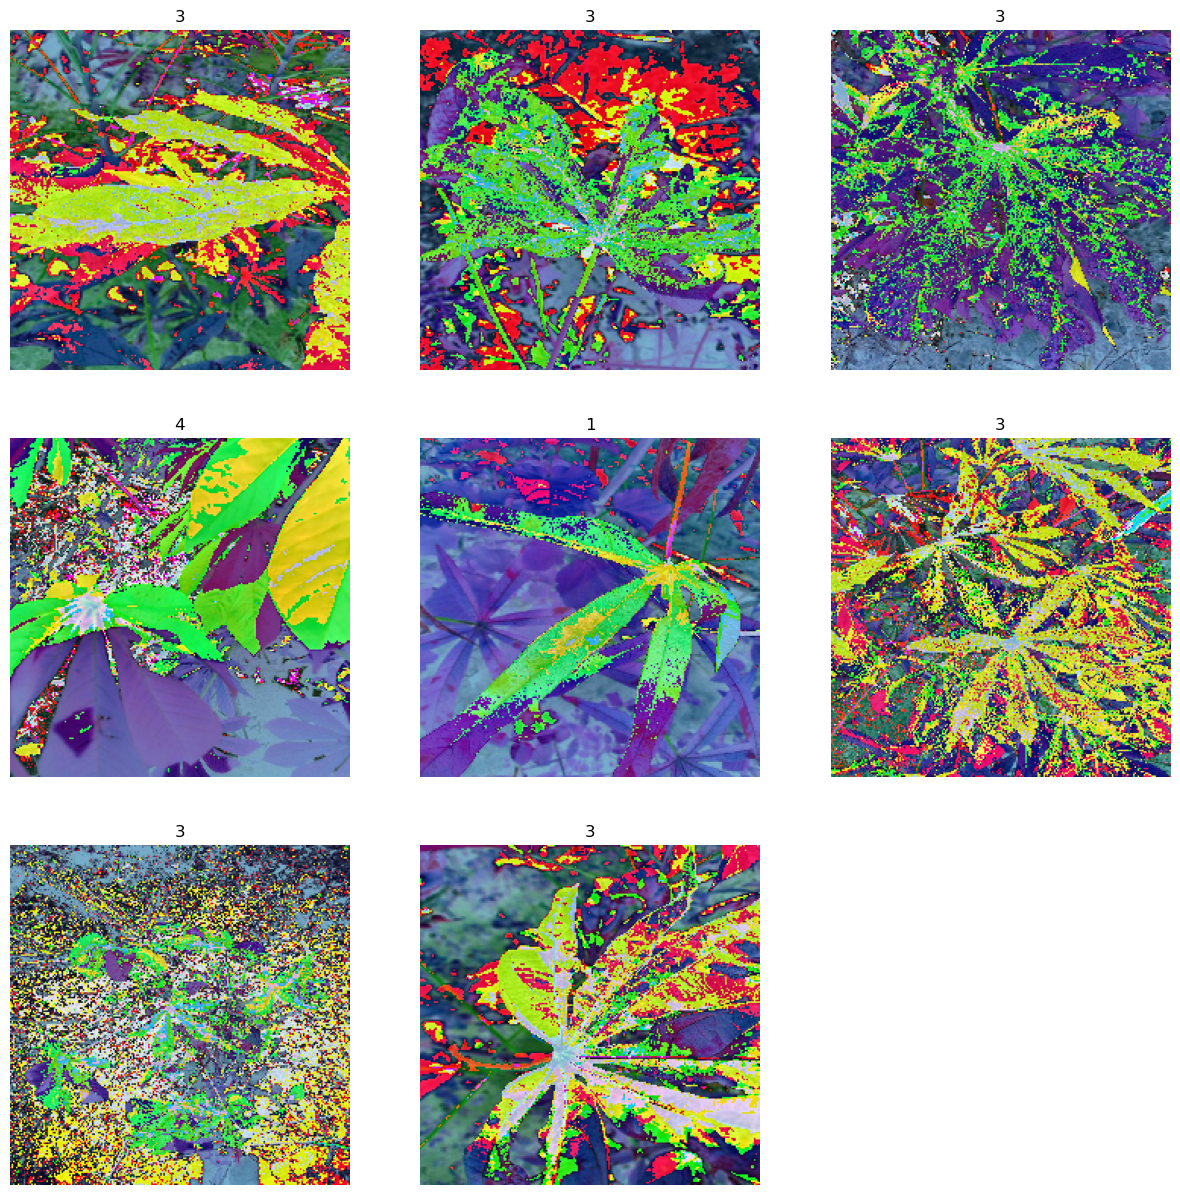

In [4]:
#show images in the training set
plt.figure(figsize=(15, 15))
print('Training images')
for images, labels in train_data_loader:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i] * 255).astype("uint8"))
        plt.title(np.argmax(labels[i]))
        plt.axis("off")
    break
plt.show()

In [5]:
#pring out training image and traning label shapes
print(labels.shape)
labels # one-hot coding automatically
images.shape

(32, 5)


(32, 224, 224, 3)

In [6]:
#Set up modal as keras Sequential, using ResNet50 pretrained model
#input shape (224,224,3)
#using imagenet pretrained weights
#and average pooling
model=keras.models.Sequential()
model.add(ResNet50( include_top = False,
                    input_tensor = None,
                    input_shape=(224, 224, 3),
                    pooling="avg",
                    classes=5,
                    weights="imagenet"))


#creating model layers -- Flatten, Dense(512), Dropout, BatchNormaliztion, Dense(256), Dropout, BactchNomaliztion
# Dense(5)-- output layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [7]:
# Compile model using Adam optimizer
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 3e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#try reducing learning rate when it plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.7)

In [8]:
#train the model - using 10 epochs to start
history=model.fit(train_data_loader,
                  validation_data=val_data_loader, 
                  batch_size=32, epochs=30, verbose=1, callbacks=[reduce_lr])


Epoch 1/30
428/428 [==============================] - 134s 293ms/step - loss: 1.3097 - accuracy: 0.5429 - val_loss: 0.7939 - val_accuracy: 0.7172
Epoch 2/30
428/428 [==============================] - 124s 290ms/step - loss: 0.9716 - accuracy: 0.6630 - val_loss: 0.7918 - val_accuracy: 0.7155
Epoch 3/30
428/428 [==============================] - 128s 298ms/step - loss: 0.8981 - accuracy: 0.6792 - val_loss: 0.7423 - val_accuracy: 0.7336
Epoch 4/30
428/428 [==============================] - 124s 290ms/step - loss: 0.8358 - accuracy: 0.6950 - val_loss: 0.7387 - val_accuracy: 0.7347
Epoch 5/30
428/428 [==============================] - 126s 295ms/step - loss: 0.7995 - accuracy: 0.7075 - val_loss: 0.7260 - val_accuracy: 0.7309
Epoch 6/30
428/428 [==============================] - 125s 292ms/step - loss: 0.7891 - accuracy: 0.7104 - val_loss: 0.7097 - val_accuracy: 0.7385
Epoch 7/30
428/428 [==============================] - 127s 297ms/step - loss: 0.7650 - accuracy: 0.7158 - val_loss: 0.7019 -

In [12]:
#save the model
model.save('Harris_ResNet50.h5')

In [14]:
#path for test images
test_path = "cassava-leaf-disease-classification/test_imgs_1"

#open file
with open('./Harris_test_labels.csv', 'w', newline="") as file:
    
    #create csv writer variable
    csv_writer = csv.writer(file, delimiter = ',')    
    csv_writer.writerow(['image_id', "label"])
    
    #create for loop going through each image
    for filename in os.listdir(test_path):
        
        #open the image with pillow
        test_img = Image.open(os.path.join("cassava-leaf-disease-classification/test_imgs_1", filename))
        
        #resize the image to match model and convert to rgb color channel
        new_size = (224,224)
        test_img = test_img.resize(new_size)
        test_img = test_img.convert("RGB")
        test_img = img_to_array(test_img)
        #test_img = img.reshape(-1, 224, 224, 3)
        test_batch = np.expand_dims(test_img, axis=0)
        test_preprocessed = preprocess_input(test_batch)
        
        #predict on the image
        pred_result = model.predict(test_preprocessed)
        
        #change from one-hot to label
        pred_result = np.argmax(pred_result, axis = 1)
        
        #Format prediction for .csv output, removing brackets
        pred_result = str(pred_result)
        pred_result = pred_result.replace("[",'')
        pred_result = pred_result.replace("]",'')
        
        #write to csv
        csv_writer.writerow([filename, pred_result])


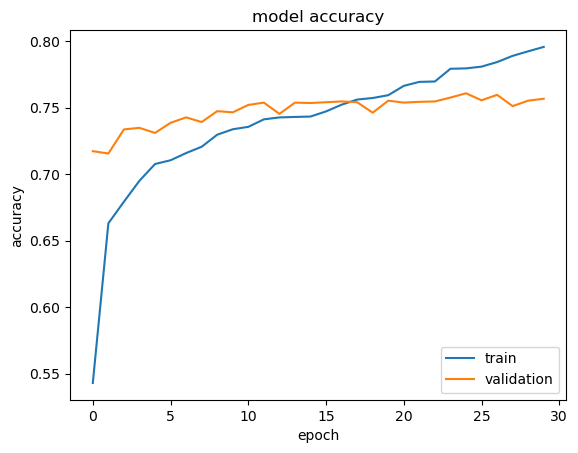

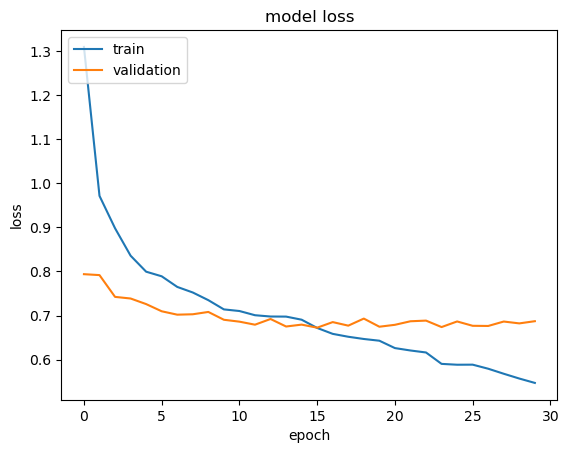

In [11]:
#accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
